In [1]:
import numpy as np

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For the dilogarithm
from scipy.special import spence

#For increased precision
import mpmath as mp
mp.mp.dps = 30

In [2]:
def Li2(x):
    # spence doesn't work with mp, so have to 
    # convert back to numpy
    x = np.complex128(x)
    return spence(1-x)

def DiLog(u, e):
    # np.where doesn't work with mp, so have to
    # convert back to numpy
    e = np.complex128(e)
    return np.where(e < 0, Li2(u), -0.5*mp.log(1/(1-u))**2-Li2(u/(u-1)))

def KallenL(x, y, z):
    return x**2 + y**2 + z**2 - 2*x*y - 2*x*z - 2*y*z

def DiLog_fn(x, z, e):
    argm = 2*e/(-1+x**2 + z**2 - mp.sqrt(KallenL(1, x**2, z**2)))
    argp = 2*e/(-1+x**2 + z**2 + mp.sqrt(KallenL(1, x**2, z**2)))
    return DiLog(argm, e) + DiLog(argp, -e)

#Special case of the ScalarC0 function from PackageX
def C0(x,y,z):  
    Dxy = DiLog_fn(x, z, -1+z**2) - DiLog_fn(x, z, -1+x**2+z**2) 
    Dyx = DiLog_fn(y, z, -1+z**2) - DiLog_fn(y, z, -1+y**2+z**2)
    
    return (Dxy - Dyx)/(x**2 - y**2)

def B(x, y):
    arg = (1-x**2+y**2 + mp.sqrt(KallenL(1, x**2, y**2)))/(2*y)
    return mp.sqrt(KallenL(1, x**2, y**2))*mp.log(arg)/x**2

In [3]:
def fBik(x, y, z):
    return ((2*z+y)*x**2 - (2*x + y)*(z**2 + 2*x*z - 1))/(x*(x**2 - y**2))

def fBjk(x, y, z):  
    return fBik(y, x, z)

def fLog(x, y, z): 
    return -(((x+y)*(1-z**2)-x*y*z)**2 - 3*(x*y*z)**2)/(x**3*y**3)

def fConst(x, y, z):  
    return -(1+x*y-z**2)/(x*y)

def fC0(x, y, z): 
    return -2*(x+y+z)*z

def f(x, y, z):
    if hasattr(x, '__iter__'):
        return np.array([f(x_, y_, z_) for x_,y_,z_ in zip(x,y,z)])
    
    #increased precision
    x = mp.mpc(x)
    y = mp.mpc(y)
    z = mp.mpc(z)
    
    f_val = fBik(x, y, z)*B(x, z)
    f_val+= fBjk(x, y, z)*B(y, z)
    f_val+= fLog(x, y, z)*mp.log(z)
    f_val+= fConst(x, y, z)
    f_val+= fC0(x, y, z)*C0(x, y, z)
    
    return np.complex128(f_val)

def f_plus(x, y, z):
    return (f(x, y, z) + f(-x, -y, z))/2

def f_minus(x, y, z):
    return (f(x, y, z) - f(-x, -y, z))/2

In [4]:
#approximations
def f_minus_iji(xi):
    f_val = -2 + (xi - 3)*xi/(xi-1)*np.log(xi)
    f_val-= 2*np.sqrt(xi*(xi-4))*np.log((xi + np.sqrt(xi*(xi-4)))/(2*np.sqrt(xi)))
    f_val-= np.log((xi + np.sqrt(xi*(xi-4)))/(2*xi))**2
    f_val-= 2*Li2(1-xi)
    f_val-= 2*Li2((xi-np.sqrt(xi*(xi-4)))/(2*xi))
    f_val+= 2*Li2((2-xi-np.sqrt(xi*(xi-4)))/2)
    return f_val

def f_plus_iji(xi):
    f_val = 2*xi - 3 - (xi - 3)*xi*np.log(xi)
    f_val+= 2*(xi-1)*np.sqrt(xi*(xi-4))*np.log((xi + np.sqrt(xi*(xi-4)))/(2*np.sqrt(xi)))
    f_val-= np.log((xi + np.sqrt(xi*(xi-4)))/(2*xi))**2
    f_val-= 2*Li2(1-xi)
    f_val-= 2*Li2((xi-np.sqrt(xi*(xi-4)))/(2*xi))
    f_val+= 2*Li2((2-xi-np.sqrt(xi*(xi-4)))/2)
    return f_val

def f_minus_small_k(xi, xk):
    f_val = 1 + (np.log((xi-1)*xk/xi) + xi - 1)*np.log((xi-1)/xi) + Li2(1/xi)
    return np.conjugate(-2*np.sqrt(xi)/np.sqrt(xk)*f_val)

def f_plus_small_k(xi):
    return np.conjugate((-1 + 2*xi + 2*(xi-1)*xi*np.log((xi-1)/xi)))

def f_minus_large_k(xi, xk):
    return np.sqrt(xk/xi)*(-(3*xk-1)/(xk-1)**2 + 2*xk**2/(xk-1)**3 * np.log(xk))

def f_plus_large_k(xi, xj, xk):
    f_val = (2*xk**2 + 5*xk - 1)/(6*(xk-1)**3) - xk**2/(xk-1)**4 * np.log(xk)
    return xk*(1/xi+1/np.sqrt(xi*xj)) * f_val

In [5]:
#Check over a large range of masses
m = np.logspace(-4,4,1000, dtype=np.complex128)
me = 5.11e-4
mm = 0.106
mt = 1.77

ue = me/m
um = mm/m
ut = mt/m

xe = m**2/me**2
xm = m**2/mm**2
xt = m**2/mt**2

In [6]:
def f_large_m(x, y, z):
    return -2*z*(x+y+z)*(1+2*np.log(z))+((x+y)**2 - 3*(x+y)*z+6*z**2+12*z**2*np.log(z))

def f_minus_large_m(x, y, z):
    return -(x+y)*z*(3 + 4*np.log(z))

def f_plus_large_m(x, y):
    return (x+y)**2/3

In [7]:
#For F2

#mu to e
fp_mee = np.where(xm < 1e6, f_plus(um, ue, ue), f_plus_large_m(um, ue))
fp_mem = np.where(xm < 1e6, f_plus(um, ue, um), f_plus_large_m(um, ue))
fp_met = np.where(xm < 1e6, f_plus(um, ue, ut), f_plus_large_m(um, ue))

fm_mee = np.where(xm < 1e6, f_minus(um, ue, ue), f_minus_large_m(um, ue, ue))
fm_mem = np.where(xm < 1e6, f_minus(um, ue, um), f_minus_large_m(um, ue, um))
fm_met = np.where(xm < 1e6, f_minus(um, ue, ut), f_minus_large_m(um, ue, ut))

#tau to e
fp_tee = f_plus(ut, ue, ue)
fp_tem = f_plus(ut, ue, um)
fp_tet = f_plus(ut, ue, ut)

fm_tee = f_minus(ut, ue, ue)
fm_tem = f_minus(ut, ue, um)
fm_tet = f_minus(ut, ue, ut)


#tau to mu
fp_tme = f_plus(ut, um, ue)
fp_tmm = f_plus(ut, um, um)
fp_tmt = f_plus(ut, um, ut)

fm_tme = f_minus(ut, um, ue)
fm_tmm = f_minus(ut, um, um)
fm_tmt = f_minus(ut, um, ut)

#For F3

#mu to e
fp3_mee = np.where(xm < 1e6, f_plus(um, -ue, ue), f_plus_large_m(um, -ue))
fp3_mem = np.where(xm < 1e6, f_plus(um, -ue, um), f_plus_large_m(um, -ue))
fp3_met = np.where(xm < 1e6, f_plus(um, -ue, ut), f_plus_large_m(um, -ue))

fm3_mee = np.where(xm < 1e6, f_minus(um, -ue, ue), f_minus_large_m(um, -ue, ue))
fm3_mem = np.where(xm < 1e6, f_minus(um, -ue, um), f_minus_large_m(um, -ue, um))
fm3_met = np.where(xm < 1e6, f_minus(um, -ue, ut), f_minus_large_m(um, -ue, ut))


#tau to e
fp3_tee = f_plus(ut, -ue, ue)
fp3_tem = f_plus(ut, -ue, um)
fp3_tet = f_plus(ut, -ue, ut)

fm3_tee = f_minus(ut, -ue, ue)
fm3_tem = f_minus(ut, -ue, um)
fm3_tet = f_minus(ut, -ue, ut)


#tau to mu
fp3_tme = f_plus(ut, -um, ue)
fp3_tmm = f_plus(ut, -um, um)
fp3_tmt = f_plus(ut, -um, ut)

fm3_tme = f_minus(ut, -um, ue)
fm3_tmm = f_minus(ut, -um, um)
fm3_tmt = f_minus(ut, -um, ut)

In [8]:
def error(x, y):
    return np.abs((y-x))
def rel_error(x, y):
    return np.abs((y-x)/x)

We begin by looking at the function $f_+(\mu_i, \mu_j, \mu_k)$ for the scenario $i = k$.

/Users/roman/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


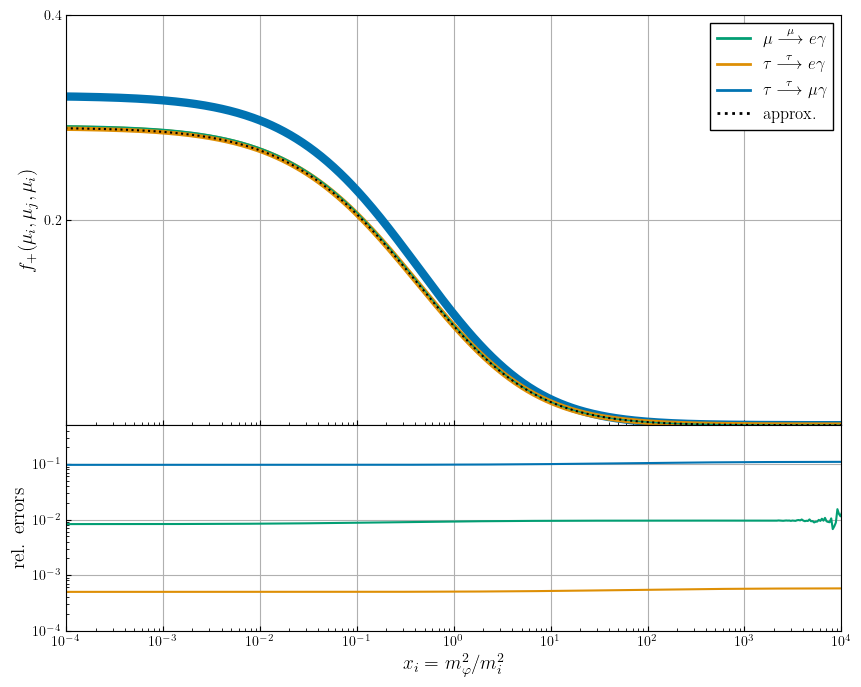

In [9]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
ax1.plot(xt, fp_tmt, color=colors[0], linewidth = 6)
ax1.plot(xt, fp_tet, color=colors[1], linewidth = 4)
ax1.plot(xm, fp_mem, color=colors[2], linewidth = 1)

#Approximation
ax1.plot(xt, f_plus_iji(xt), color='black', linestyle="dotted")

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[2], linewidth = 2)
ax1.plot([1000], label="$\\tau \\stackrel{\\tau}{\\longrightarrow} e\\gamma$", color=colors[1], linewidth = 2)
ax1.plot([1000], label="$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$", color=colors[0], linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)

#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$f_+(\\mu_i, \\mu_j, \\mu_i)$", fontsize = 14)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylim(0, 0.4)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(fp_tmt, f_plus_iji(xt)), color=colors[0])
ax2.plot(xm, rel_error(fp_tet, f_plus_iji(xt)), color=colors[1])
ax2.plot(xm, rel_error(fp_mem, f_plus_iji(xm)), color=colors[2])

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_i=m_\\varphi^2/m_i^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-4,5e-1)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

/Users/roman/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


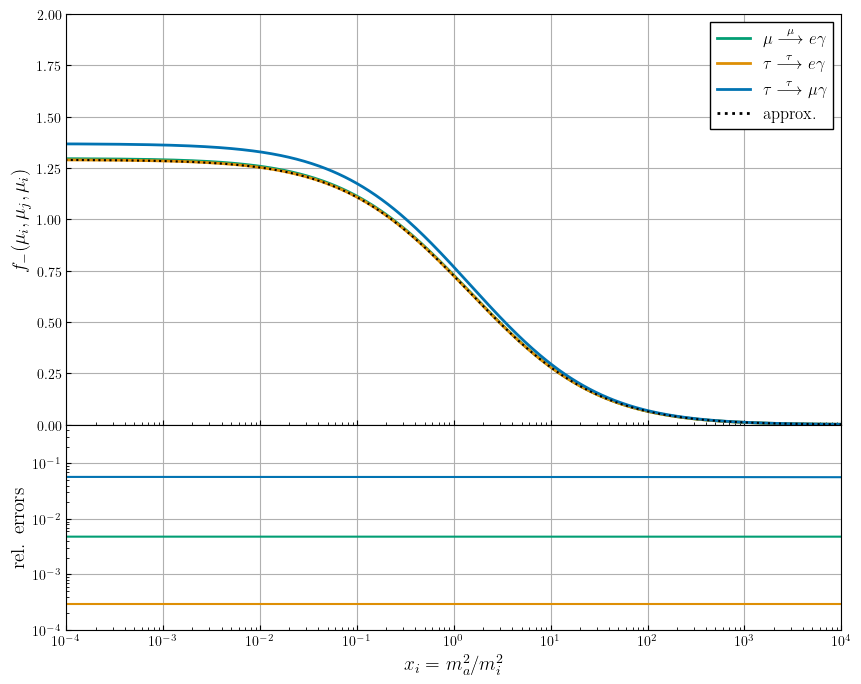

In [10]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
ax1.plot(xm, fm_mem, color=colors[2], linewidth = 2)
ax1.plot(xt, fm_tet, color=colors[1], linewidth = 2)
ax1.plot(xt, fm_tmt, color=colors[0], linewidth = 2)

#Approximation
ax1.plot(xt, f_minus_iji(xt), color='black', linestyle="dotted")

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[2], linewidth = 2)
ax1.plot([1000], label="$\\tau\\stackrel{\\tau}{\\longrightarrow}  e\\gamma$", color=colors[1], linewidth = 2)
ax1.plot([1000], label="$\\tau\\stackrel{\\tau}{\\longrightarrow} \\mu\\gamma$", color=colors[0], linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)

#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$f_-(\\mu_i, \\mu_j, \\mu_i)$", fontsize = 14)
ax1.set_ylim(0, 2)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(fm_mem, f_minus_iji(xm)), color=colors[2])
ax2.plot(xm, rel_error(fm_tet, f_minus_iji(xt)), color=colors[1])
ax2.plot(xm, rel_error(fm_tmt, f_minus_iji(xt)), color=colors[0])

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_i=m_a^2/m_i^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-4,0.5)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

(0.0001, 10000.0)

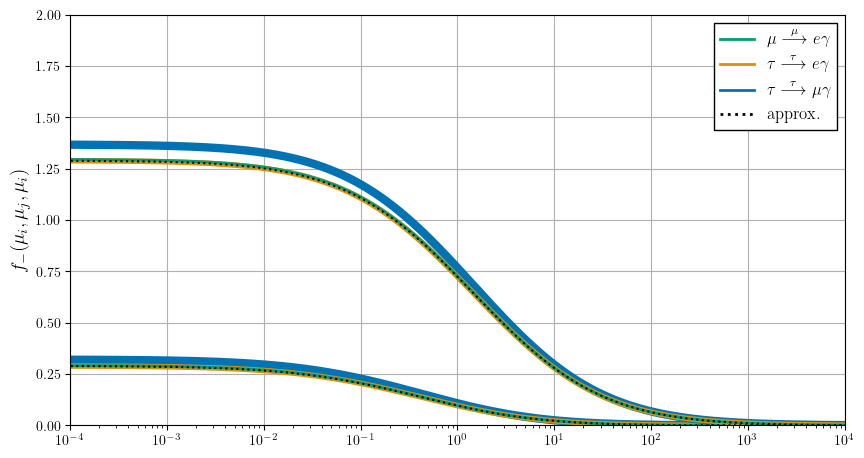

In [11]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
ax1.plot(xt, fp_tmt, color=colors[0], linewidth = 6)
ax1.plot(xt, fp_tet, color=colors[1], linewidth = 4)
ax1.plot(xm, fp_mem, color=colors[2], linewidth = 2)

#Exact results
ax1.plot(xt, fm_tmt, color=colors[0], linewidth = 6)
ax1.plot(xt, fm_tet, color=colors[1], linewidth = 4)
ax1.plot(xm, fm_mem, color=colors[2], linewidth = 2)

#Approximation
ax1.plot(xt, f_plus_iji(xt), color='black', linestyle="dotted")
ax1.plot(xt, f_minus_iji(xt), color='black', linestyle="dotted")

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[2], linewidth = 2)
ax1.plot([1000], label="$\\tau\\stackrel{\\tau}{\\longrightarrow}  e\\gamma$", color=colors[1], linewidth = 2)
ax1.plot([1000], label="$\\tau\\stackrel{\\tau}{\\longrightarrow} \\mu\\gamma$", color=colors[0], linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)

#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$f_-(\\mu_i, \\mu_j, \\mu_i)$", fontsize = 14)
ax1.set_ylim(0, 2)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

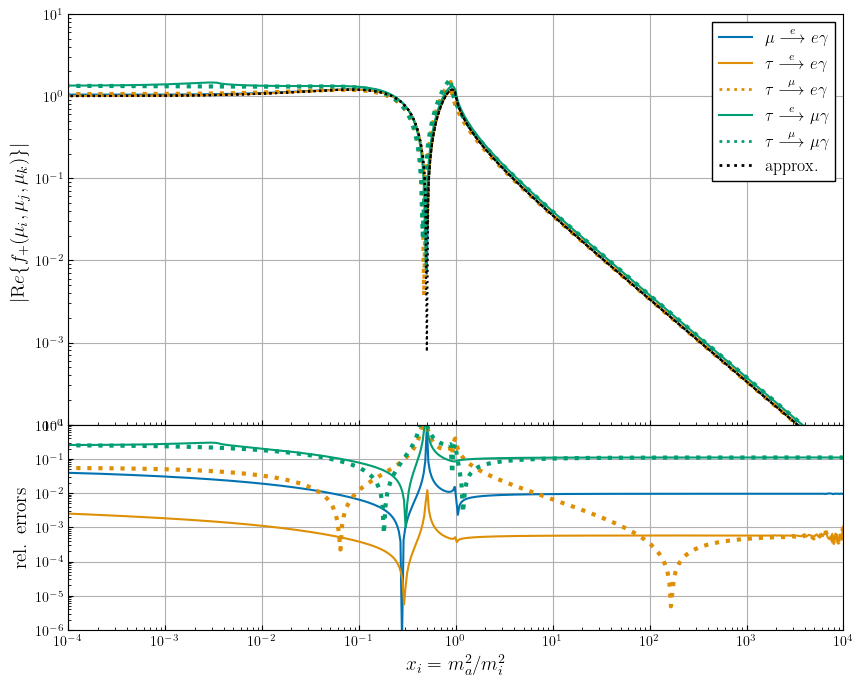

In [12]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
plt.plot(xm, np.abs(np.real(fp_mee)), color = colors[0])
plt.plot(xt, np.abs(np.real(fp_tee)), color = colors[1])
plt.plot(xt, np.abs(np.real(fp_tem)), color = colors[1], linestyle = 'dotted', linewidth = 3)
plt.plot(xt, np.abs(np.real(fp_tme)), color = colors[2])
plt.plot(xt, np.abs(np.real(fp_tmm)), color = colors[2], linestyle = 'dotted', linewidth = 3)


#Approximation
plt.plot(xm, np.abs(np.real(f_plus_small_k(xm))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.real(f_plus_small_k(xt))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.real(f_plus_small_k(xt))), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[0])
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[1])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[1], linestyle = 'dotted', linewidth = 2)
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$", color=colors[2])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$", color=colors[2], linestyle = 'dotted', linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)


#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$|{\\textrm Re}\{f_+(\\mu_i, \\mu_j, \\mu_k)\}|$", fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim(1e-4, 1e1)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(np.real(fp_mee), np.real(f_plus_small_k(xm))), color = colors[0])
ax2.plot(xt, rel_error(np.real(fp_tee), np.real(f_plus_small_k(xt))), color = colors[1])
ax2.plot(xt, rel_error(np.real(fp_tem), np.real(f_plus_small_k(xt))), color = colors[1], linestyle = 'dotted', linewidth = 3)
ax2.plot(xt, rel_error(np.real(fp_tme), np.real(f_plus_small_k(xt))), color = colors[2])
ax2.plot(xt, rel_error(np.real(fp_tmm), np.real(f_plus_small_k(xt))), color = colors[2], linestyle = 'dotted', linewidth = 3)

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_i=m_a^2/m_i^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-6,1e0)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_45484/4213155636.py:4: RuntimeWarning: invalid value encountered in divide
  return np.abs((y-x)/x)


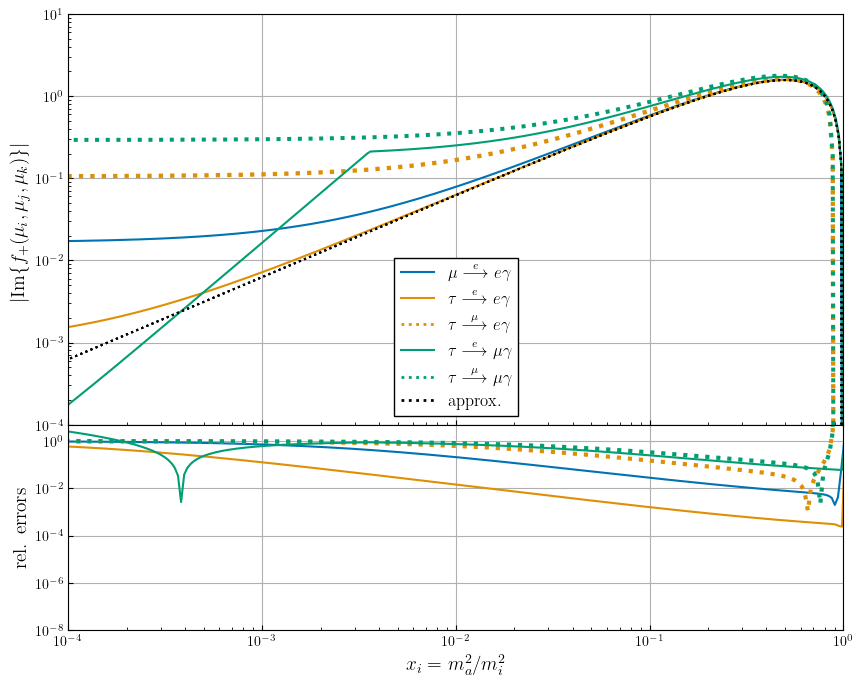

In [13]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
plt.plot(xm, np.abs(np.imag(fp_mee)), color = colors[0])
plt.plot(xt, np.abs(np.imag(fp_tee)), color = colors[1])
plt.plot(xt, np.abs(np.imag(fp_tem)), color = colors[1], linestyle = 'dotted', linewidth = 3.1)
plt.plot(xt, np.abs(np.imag(fp_tme)), color = colors[2])
plt.plot(xt, np.abs(np.imag(fp_tmm)), color = colors[2], linestyle = 'dotted', linewidth = 2.9)


#Approximation
plt.plot(xm, np.abs(np.imag(f_plus_small_k(xm))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.imag(f_plus_small_k(xt))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.imag(f_plus_small_k(xt))), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[0])
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[1])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[1], linestyle = 'dotted', linewidth = 2)
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$", color=colors[2])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$", color=colors[2], linestyle = 'dotted', linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)


#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$|{\\textrm{Im}}\{f_+(\\mu_i, \\mu_j, \\mu_k)\}|$", fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim(1e-4, 1e1)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(np.imag(fp_mee), np.imag(f_plus_small_k(xm))), color = colors[0])
ax2.plot(xt, rel_error(np.imag(fp_tee), np.imag(f_plus_small_k(xt))), color = colors[1])
ax2.plot(xt, rel_error(np.imag(fp_tem), np.imag(f_plus_small_k(xt))), color = colors[1], linestyle = 'dotted', linewidth = 3)
ax2.plot(xt, rel_error(np.imag(fp_tme), np.imag(f_plus_small_k(xt))), color = colors[2])
ax2.plot(xt, rel_error(np.imag(fp_tmm), np.imag(f_plus_small_k(xt))), color = colors[2], linestyle = 'dotted', linewidth = 3)

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_{i}=m_a^2/m_i^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-8,5)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

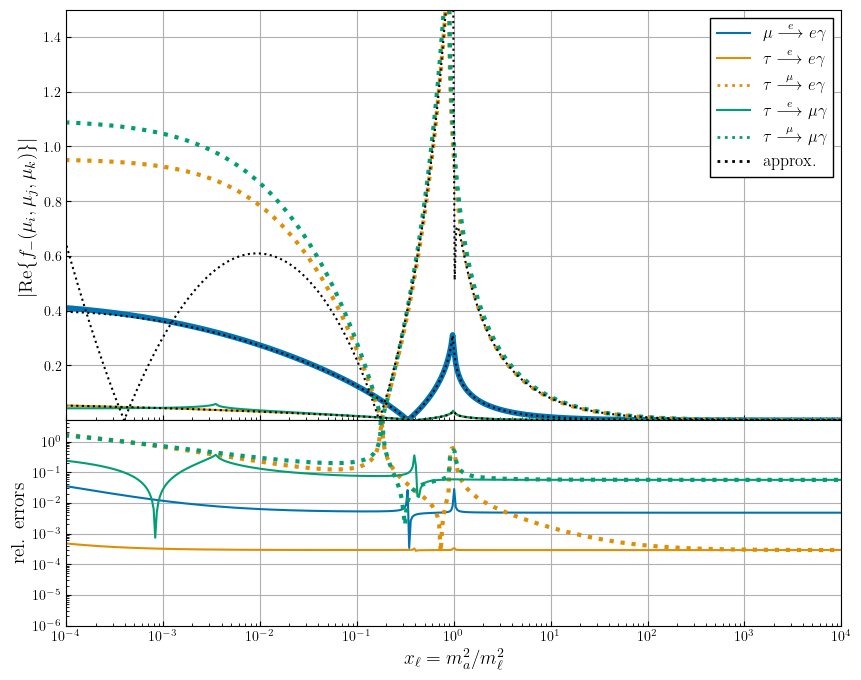

In [14]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
plt.plot(xm, np.abs(np.real(fm_mee)), color = colors[0], linewidth = 4)
plt.plot(xt, np.abs(np.real(fm_tee)), color = colors[1])
plt.plot(xt, np.abs(np.real(fm_tem)), color = colors[1], linestyle = 'dotted', linewidth = 3)
plt.plot(xt, np.abs(np.real(fm_tme)), color = colors[2])
plt.plot(xt, np.abs(np.real(fm_tmm)), color = colors[2], linestyle = 'dotted', linewidth = 3)


#Approximation
plt.plot(xm, np.abs(np.real(f_minus_small_k(xm, xe))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.real(f_minus_small_k(xt, xe))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.real(f_minus_small_k(xt, xm))), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[0])
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[1])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[1], linestyle = 'dotted', linewidth = 2)
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$", color=colors[2])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$", color=colors[2], linestyle = 'dotted', linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)



#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$|{\\textrm{Re}}\{f_-(\\mu_i, \\mu_j, \\mu_k)\}|$", fontsize = 14)
#ax1.set_yscale('log')
ax1.set_ylim(1e-4, 1.5)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(np.real(fm_mee), np.real(f_minus_small_k(xm, xe))), color = colors[0])
ax2.plot(xt, rel_error(np.real(fm_tee), np.real(f_minus_small_k(xt, xe))), color = colors[1])
ax2.plot(xt, rel_error(np.real(fm_tem), np.real(f_minus_small_k(xt, xm))), color = colors[1], linestyle = 'dotted', linewidth = 3)
ax2.plot(xt, rel_error(np.real(fm_tme), np.real(f_minus_small_k(xt, xe))), color = colors[2])
ax2.plot(xt, rel_error(np.real(fm_tmm), np.real(f_minus_small_k(xt, xm))), color = colors[2], linestyle = 'dotted', linewidth = 3)

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_{\ell}=m_a^2/m_\ell^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-6,5)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_45484/4213155636.py:4: RuntimeWarning: invalid value encountered in divide
  return np.abs((y-x)/x)


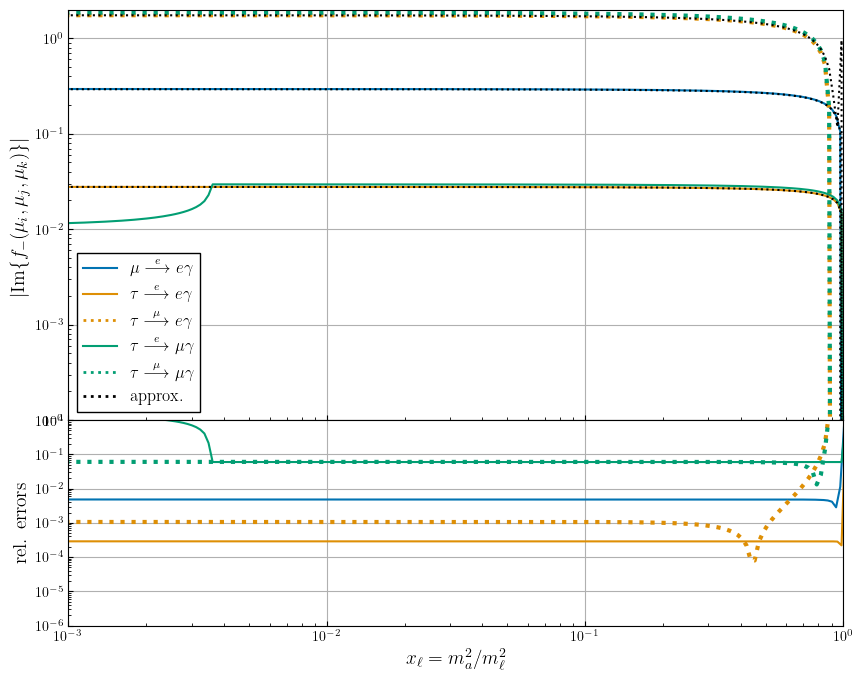

In [15]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
plt.plot(xm, np.abs(np.imag(fm_mee)), color = colors[0])
plt.plot(xt, np.abs(np.imag(fm_tee)), color = colors[1])
plt.plot(xt, np.abs(np.imag(fm_tem)), color = colors[1], linestyle = 'dotted', linewidth = 3)
plt.plot(xt, np.abs(np.imag(fm_tme)), color = colors[2])
plt.plot(xt, np.abs(np.imag(fm_tmm)), color = colors[2], linestyle = 'dotted', linewidth = 3)


#Approximation
plt.plot(xm, np.abs(np.imag(f_minus_small_k(xm, xe))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.imag(f_minus_small_k(xt, xe))), color = 'black', linestyle = 'dotted')
plt.plot(xt, np.abs(np.imag(f_minus_small_k(xt, xm))), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[0])
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} e\\gamma$", color=colors[1])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} e\\gamma$", color=colors[1], linestyle = 'dotted', linewidth = 2)
ax1.plot([1000], label="$\\tau \\stackrel{e}{\\longrightarrow} \\mu\\gamma$", color=colors[2])
ax1.plot([1000], label="$\\tau \\stackrel{\\mu}{\\longrightarrow} \\mu\\gamma$", color=colors[2], linestyle = 'dotted', linewidth = 2)

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)



#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$|{\\textrm{Im}}\{f_-(\\mu_i, \\mu_j, \\mu_k)\}|$", fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim(1e-4, 2)

ax1.set_xscale('log')
ax1.set_xlim(1e-3,1)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xm, rel_error(np.imag(fm_mee), np.imag(f_minus_small_k(xm, xe))), color = colors[0])
ax2.plot(xt, rel_error(np.imag(fm_tee), np.imag(f_minus_small_k(xt, xe))), color = colors[1])
ax2.plot(xt, rel_error(np.imag(fm_tem), np.imag(f_minus_small_k(xt, xm))), color = colors[1], linestyle = 'dotted', linewidth = 3)
ax2.plot(xt, rel_error(np.imag(fm_tme), np.imag(f_minus_small_k(xt, xe))), color = colors[2])
ax2.plot(xt, rel_error(np.imag(fm_tmm), np.imag(f_minus_small_k(xt, xm))), color = colors[2], linestyle = 'dotted', linewidth = 3)

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_{\ell}=m_a^2/m_\ell^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-6,1)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

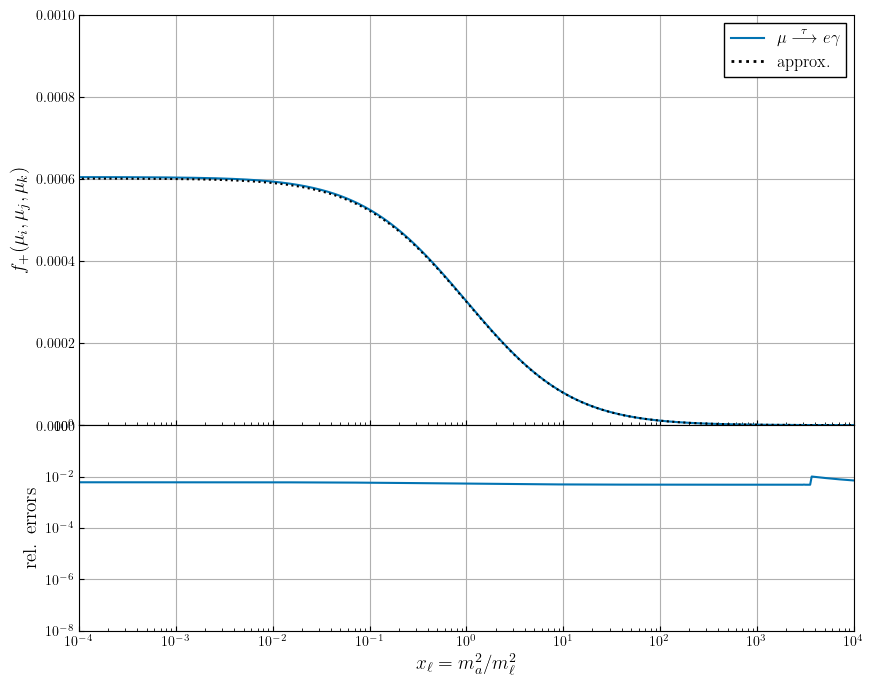

In [16]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
plt.plot(xt, fp_met, color = colors[0])

#Approximation
plt.plot(xt, f_plus_large_k(xm, xe, xt), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$", color=colors[0])

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)



#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$f_+(\\mu_i, \\mu_j, \\mu_k)$", fontsize = 14)
#ax1.set_yscale('log')
ax1.set_ylim(0, 0.001)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e4)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[1], sharex=ax1)

#Relative error
ax2.plot(xt, rel_error(fp_met, f_plus_large_k(xm, xe, xt)), color = colors[0])

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_{\ell}=m_a^2/m_\ell^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-8,1e0)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_45484/88217476.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 0.1)


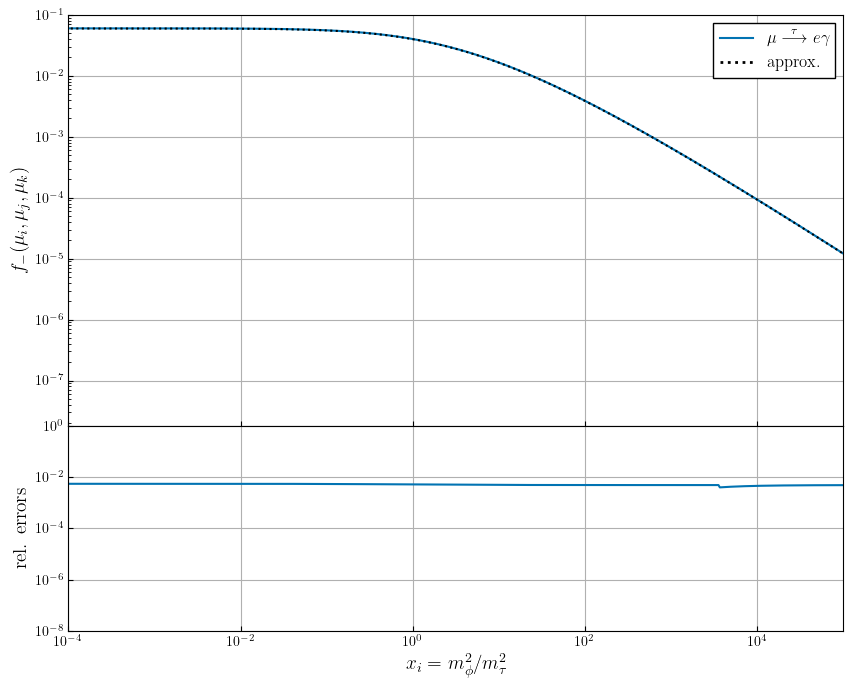

In [17]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 0, 1], hspace = 0)  # hspace=0 removes gap

# Top plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])

#Exact results
ax1.plot(xt, fm_met, color = colors[0])

#Approximation
ax1.plot(xt, f_minus_large_k(xm, xt), color = 'black', linestyle = 'dotted')

#Dummy plots for legend
ax1.plot([1000], label="$\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma$", color=colors[0])

ax1.plot([1000], label="{\\textrm{approx.}}", color='black', linestyle="dotted", linewidth = 2)

#Legend
ax1.legend(fancybox=False, facecolor = 'white', edgecolor = 'black', fontsize = 12, framealpha = 1)

#Axis specifications
ax1.grid()

ax1.set_ylabel("$f_-(\\mu_i, \\mu_j, \\mu_k)$", fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim(0, 0.1)

ax1.set_xscale('log')
ax1.set_xlim(1e-4,1e5)

# Bottom plot: Relative error
ax2 = fig.add_subplot(gs[2], sharex=ax1)

#Relative error
ax2.plot(xt, rel_error(fm_met, f_minus_large_k(xm, xt)), color = colors[0])

#Axis specifications
ax2.grid()

ax2.set_xlabel("$x_{i}=m_\\phi^2/m_\\tau^2$", fontsize = 14)

ax2.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim(1e-8,1e0)

# Remove extra tick labels from the shared x-axis of the top plot
ax1.tick_params(which = 'both', direction = 'in', labelbottom=False)
ax2.tick_params(which = 'both', direction = 'in')

plt.show()

In [18]:
fp_me_sum = fp_mee + fp_mem + fp_met
fm_me_sum = fm_mee + fm_mem + fm_met

fp_te_sum = fp_tee + fp_tem + fp_tet
fm_te_sum = fm_tee + fm_tem + fm_tet

fp_tm_sum = fp_tme + fp_tmm + fp_tmt
fm_tm_sum = fm_tme + fm_tmm + fm_tmt

#Parity-conserving scalar

#\mu -> e\gamma
PC_scalar_F2_mee = np.abs(fp_mee + fm_mee)/(32*np.pi**2)
PC_scalar_F2_mem = np.abs(fp_mem + fm_mem)/(32*np.pi**2)
PC_scalar_F2_met = np.abs(fp_met + fm_met)/(32*np.pi**2)

PC_scalar_F2_me = np.abs(fp_me_sum + fm_me_sum)/(32*np.pi**2)

#\tau -> e\gamma
PC_scalar_F2_tee = np.abs(fp_tee + fm_tee)/(32*np.pi**2)
PC_scalar_F2_tem = np.abs(fp_tem + fm_tem)/(32*np.pi**2)
PC_scalar_F2_tet = np.abs(fp_tet + fm_tet)/(32*np.pi**2)

PC_scalar_F2_te = np.abs(fp_te_sum + fm_te_sum)/(32*np.pi**2)

#\tau -> \mu \gamma
PC_scalar_F2_tme = np.abs(fp_tme + fm_tme)/(32*np.pi**2)
PC_scalar_F2_tmm = np.abs(fp_tmm + fm_tmm)/(32*np.pi**2)
PC_scalar_F2_tmt = np.abs(fp_tmt + fm_tmt)/(32*np.pi**2)

PC_scalar_F2_tm = np.abs(fp_tm_sum + fm_tm_sum)/(32*np.pi**2)

#Chiral complex scalar

#\mu -> e\gamma
chi_scalar_F2_mee = np.abs(fp_mee)/(32*np.pi**2)
chi_scalar_F2_mem = np.abs(fp_mem)/(32*np.pi**2)
chi_scalar_F2_met = np.abs(fp_met)/(32*np.pi**2)

chi_scalar_F2_me = np.abs(fp_me_sum)/(32*np.pi**2)

#\tau -> e\gamma
chi_scalar_F2_tee = np.abs(fp_tee)/(32*np.pi**2)
chi_scalar_F2_tem = np.abs(fp_tem)/(32*np.pi**2)
chi_scalar_F2_tet = np.abs(fp_tet)/(32*np.pi**2)

chi_scalar_F2_te = np.abs(fp_te_sum)/(32*np.pi**2)

#\tau -> \mu \gamma
chi_scalar_F2_tme = np.abs(fp_tme)/(32*np.pi**2)
chi_scalar_F2_tmm = np.abs(fp_tmm)/(32*np.pi**2)
chi_scalar_F2_tmt = np.abs(fp_tmt)/(32*np.pi**2)

chi_scalar_F2_tm = np.abs(fp_tm_sum)/(32*np.pi**2)


#F3
fp3_me_sum = fp3_mee + fp3_mem + fp3_met
fp3_te_sum = fp3_tee + fp3_tem + fp3_tet
fp3_tm_sum = fp3_tme + fp3_tmm + fp3_tmt

#Only chiral scalar, 0 for PC scalar

#\mu -> e\gamma
chi_scalar_F3_mee = np.abs(fp3_mee)/(32*np.pi**2)
chi_scalar_F3_mem = np.abs(fp3_mem)/(32*np.pi**2)
chi_scalar_F3_met = np.abs(fp3_met)/(32*np.pi**2)
chi_scalar_F3_me = np.abs(fp3_me_sum)/(32*np.pi**2)

#\tau -> e\gamma
chi_scalar_F3_tee = np.abs(fp3_tee)/(32*np.pi**2)
chi_scalar_F3_tem = np.abs(fp3_tem)/(32*np.pi**2)
chi_scalar_F3_tet = np.abs(fp3_tet)/(32*np.pi**2)

chi_scalar_F3_te = np.abs(fp3_te_sum)/(32*np.pi**2)

#\tau -> \mu \gamma
chi_scalar_F3_tme = np.abs(fp3_tme)/(32*np.pi**2)
chi_scalar_F3_tmm = np.abs(fp3_tmm)/(32*np.pi**2)
chi_scalar_F3_tmt = np.abs(fp3_tmt)/(32*np.pi**2)

chi_scalar_F3_tm = np.abs(fp3_tm_sum)/(32*np.pi**2)

In [19]:
alpha = 1/137

#PC

PC_scalar_rate_mee = 2*alpha*(PC_scalar_F2_mee**2) * (mm - me)**2/mm
PC_scalar_rate_mem = 2*alpha*(PC_scalar_F2_mem**2) * (mm - me)**2/mm
PC_scalar_rate_met = 2*alpha*(PC_scalar_F2_met**2) * (mm - me)**2/mm
PC_scalar_rate_me = 2*alpha*(PC_scalar_F2_me**2) * (mm - me)**2/mm

PC_scalar_rate_tee = 2*alpha*(PC_scalar_F2_tee**2) * (mt - me)**2/mt
PC_scalar_rate_tem = 2*alpha*(PC_scalar_F2_tem**2) * (mt - me)**2/mt
PC_scalar_rate_tet = 2*alpha*(PC_scalar_F2_tet**2) * (mt - me)**2/mt
PC_scalar_rate_te = 2*alpha*(PC_scalar_F2_te**2) * (mt - me)**2/mt

PC_scalar_rate_tme = 2*alpha*(PC_scalar_F2_tme**2) * (mt - mm)**2/mt
PC_scalar_rate_tmm = 2*alpha*(PC_scalar_F2_tmm**2) * (mt - mm)**2/mt
PC_scalar_rate_tmt = 2*alpha*(PC_scalar_F2_tmt**2) * (mt - mm)**2/mt
PC_scalar_rate_tm = 2*alpha*(PC_scalar_F2_tm**2) * (mt - mm)**2/mt

#chi

chi_scalar_rate_mee = 2*alpha*((mm - me)**2 * chi_scalar_F2_mee**2 + (mm + me)**2 * chi_scalar_F3_mee**2)/mm
chi_scalar_rate_mem = 2*alpha*((mm - me)**2 * chi_scalar_F2_mem**2 + (mm + me)**2 * chi_scalar_F3_mem**2)/mm
chi_scalar_rate_met = 2*alpha*((mm - me)**2 * chi_scalar_F2_met**2 + (mm + me)**2 * chi_scalar_F3_met**2)/mm
chi_scalar_rate_me = 2*alpha*((mm - me)**2 * chi_scalar_F2_me**2 + (mm + me)**2 * chi_scalar_F3_me**2)/mm

chi_scalar_rate_tee = 2*alpha*((mt - me)**2 * chi_scalar_F2_tee**2 + (mt + me)**2 * chi_scalar_F3_tee**2)/mt
chi_scalar_rate_tem = 2*alpha*((mt - me)**2 * chi_scalar_F2_tem**2 + (mt + me)**2 * chi_scalar_F3_tem**2)/mt
chi_scalar_rate_tet = 2*alpha*((mt - me)**2 * chi_scalar_F2_tet**2 + (mt + me)**2 * chi_scalar_F3_tet**2)/mt
chi_scalar_rate_te = 2*alpha*((mt - me)**2 * chi_scalar_F2_te**2 + (mt + me)**2 * chi_scalar_F3_te**2)/mt

chi_scalar_rate_tme = 2*alpha*((mt - mm)**2 * chi_scalar_F2_tme**2 + (mt + mm)**2 * chi_scalar_F3_tme**2)/mt
chi_scalar_rate_tmm = 2*alpha*((mt - mm)**2 * chi_scalar_F2_tmm**2 + (mt + mm)**2 * chi_scalar_F3_tmm**2)/mt
chi_scalar_rate_tmt = 2*alpha*((mt - mm)**2 * chi_scalar_F2_tmt**2 + (mt + mm)**2 * chi_scalar_F3_tmt**2)/mt
chi_scalar_rate_tm = 2*alpha*((mt - mm)**2 * chi_scalar_F2_tm**2 + (mt + mm)**2 * chi_scalar_F3_tm**2)/mt

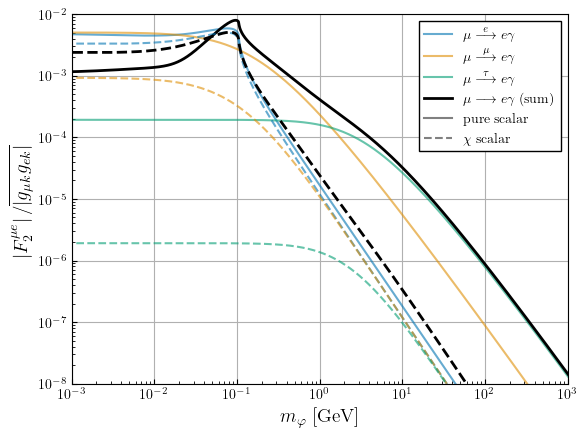

In [20]:
plt.plot(m, PC_scalar_F2_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_me, color = 'black', linewidth = 2, label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_F2_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_me, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\mu e}\\right|/\\overline{|g_{\\mu k}g_{e k}|}$", fontsize = 14)
plt.ylim(1e-8,1e-2)
plt.yscale('log')

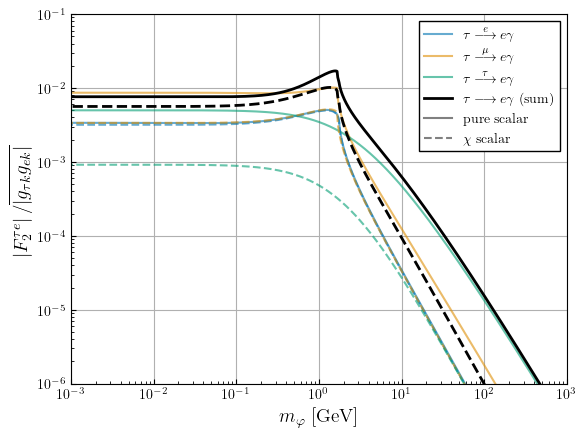

In [21]:
plt.plot(m, PC_scalar_F2_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_F2_te, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_F2_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_te, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\tau e}\\right|/\\overline{|g_{\\tau k}g_{e k}|}$", fontsize = 14)
plt.ylim(1e-6,1e-1)
plt.yscale('log')

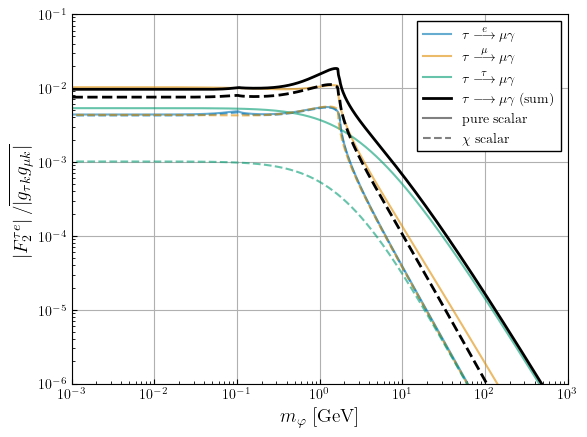

In [22]:
plt.plot(m, PC_scalar_F2_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_F2_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_F2_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_F2_tm, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_F2_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_F2_tm, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\tau e}\\right|/\\overline{|g_{\\tau k}g_{\\mu k}|}$", fontsize = 14)
plt.ylim(1e-6,1e-1)
plt.yscale('log')

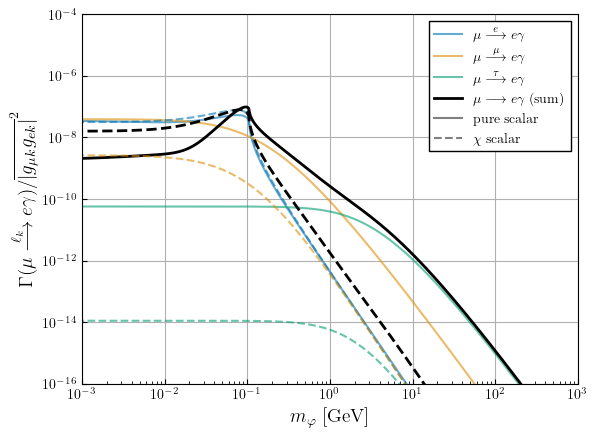

In [23]:
plt.plot(m, PC_scalar_rate_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_me, color = 'black', linewidth = 2, label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_me, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\mu \\stackrel{\\ell_k}{\\longrightarrow} e\\gamma)/\\overline{|g_{\\mu k}g_{e k}|}^2$", fontsize = 14)
plt.ylim(1e-16,1e-4)
plt.yscale('log')

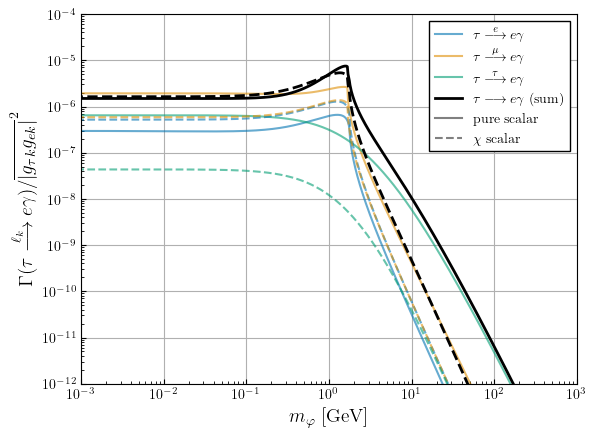

In [24]:
plt.plot(m, PC_scalar_rate_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_te, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_te, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\tau \\stackrel{\\ell_k}{\\longrightarrow} e\\gamma)/\\overline{|g_{\\tau k}g_{e k}|}^2$", fontsize = 14)
plt.ylim(1e-12,1e-4)
plt.yscale('log')

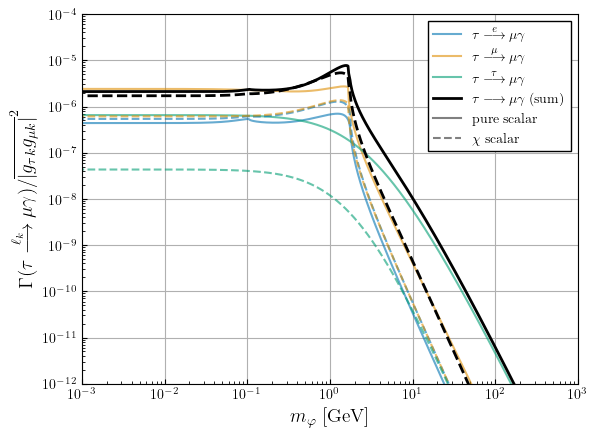

In [25]:
plt.plot(m, PC_scalar_rate_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tm, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tm, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\tau \\stackrel{\\ell_k}{\\longrightarrow} \\mu\\gamma)/\\overline{|g_{\\tau k}g_{\\mu k}|}^2$", fontsize = 14)
plt.ylim(1e-12,1e-4)
plt.yscale('log')

In [26]:
Lam = 1000

def g2(x):
    return 0.5*(x-1)*np.log(x-1) - x**2 * np.log(x)/(2*(x-1))

def I1(x):
    return np.log(1000**2 * x/m) + 2 + g2(x)

cgg = -1/(8*np.pi**2)

PC_ALP_F2_mee = (mm + me)*(me + me) * (fp_mee - fm_mee)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_mem = (mm + mm)*(me + mm) * (fp_mem - fm_mem)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_met = (mm + mt)*(me + mt) * (fp_met - fm_met)/(32*np.pi**2 * Lam**2)

PC_ALP_F2_meg = alpha/(2*np.pi) * mm**2/Lam**2 * cgg * I1(xm)

PC_ALP_F2_me = np.abs(PC_ALP_F2_mee + PC_ALP_F2_mem + PC_ALP_F2_met + 3*PC_ALP_F2_meg)

PC_ALP_F2_tee = (mt + me)*(me + me) * (fp_tee - fm_tee)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_tem = (mt + mm)*(me + mm) * (fp_tem - fm_tem)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_tet = (mt + mt)*(me + mt) * (fp_tet - fm_tet)/(32*np.pi**2 * Lam**2)

PC_ALP_F2_teg = alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

PC_ALP_F2_te = np.abs(PC_ALP_F2_tee + PC_ALP_F2_tem + PC_ALP_F2_tet + 3*PC_ALP_F2_teg)

PC_ALP_F2_tme = (mt + me)*(mm + me) * (fp_tee - fm_tee)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_tmm = (mt + mm)*(mm + mm) * (fp_tem - fm_tem)/(32*np.pi**2 * Lam**2)
PC_ALP_F2_tmt = (mt + mt)*(mm + mt) * (fp_tet - fm_tet)/(32*np.pi**2 * Lam**2)

PC_ALP_F2_tmg = alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

PC_ALP_F2_tm = np.abs(PC_ALP_F2_tme + PC_ALP_F2_tmm + PC_ALP_F2_tmt + 3*PC_ALP_F2_tmg)


#
chi_ALP_F2_mee = ((mm + me)*me*fm_mee - (mm*me + me**2)*fp_mee)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_mem = ((mm + me)*mm*fm_mem - (mm*me + mm**2)*fp_mem)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_met = ((mm + me)*mt*fm_met - (mm*me + mt**2)*fp_met)/(32*np.pi**2 * Lam**2)

chi_ALP_F2_meg = alpha/(2*np.pi) * mm**2/Lam**2 * cgg * I1(xm)

chi_ALP_F2_me = np.abs(chi_ALP_F2_mee + chi_ALP_F2_mem + chi_ALP_F2_met + 3*chi_ALP_F2_meg)

chi_ALP_F2_tee = ((mt + me)*me*fm_tee - (mt*me + me**2)*fp_tee)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_tem = ((mt + me)*mm*fm_tem - (mt*me + mm**2)*fp_tem)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_tet = ((mt + me)*mt*fm_tet - (mt*me + mt**2)*fp_tet)/(32*np.pi**2 * Lam**2)

chi_ALP_F2_teg = alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

chi_ALP_F2_te = np.abs(chi_ALP_F2_tee + chi_ALP_F2_tem + chi_ALP_F2_tet + 3*chi_ALP_F2_teg)

chi_ALP_F2_tme = ((mt + mm)*me*fm_tee - (mt*mm + me**2)*fp_tee)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_tmm = ((mt + mm)*mm*fm_tem - (mt*mm + mm**2)*fp_tem)/(32*np.pi**2 * Lam**2)
chi_ALP_F2_tmt = ((mt + mm)*mt*fm_tet - (mt*mm + mt**2)*fp_tet)/(32*np.pi**2 * Lam**2)

chi_ALP_F2_tmg = alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

chi_ALP_F2_tm = np.abs(chi_ALP_F2_tme + chi_ALP_F2_tmm + chi_ALP_F2_tmt + 3*chi_ALP_F2_tmg)

#F3
chi_ALP_F3_mee = ((mm - me)*me*fm3_mee - (mm*me - me**2)*fp3_mee)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_mem = ((mm - me)*mm*fm3_mem - (mm*me - mm**2)*fp3_mem)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_met = ((mm - me)*mt*fm3_met - (mm*me - mt**2)*fp3_met)/(32*np.pi**2 * Lam**2)

chi_ALP_F3_meg = 1j*alpha/(2*np.pi) * mm**2/Lam**2 * cgg * I1(xm)

chi_ALP_F3_me = np.abs(chi_ALP_F3_mee + chi_ALP_F3_mem + chi_ALP_F3_met + 3*chi_ALP_F3_meg)

chi_ALP_F3_tee = ((mt - me)*me*fm3_tee - (mt*me - me**2)*fp3_tee)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_tem = ((mt - me)*mm*fm3_tem - (mt*me - mm**2)*fp3_tem)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_tet = ((mt - me)*mt*fm3_tet - (mt*me - mt**2)*fp3_tet)/(32*np.pi**2 * Lam**2)

chi_ALP_F3_teg = 1j*alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

chi_ALP_F3_te = np.abs(chi_ALP_F3_tee + chi_ALP_F3_tem + chi_ALP_F3_tet + 3*chi_ALP_F3_teg)

chi_ALP_F3_tme = ((mt - mm)*me*fm3_tee - (mt*mm - me**2)*fp3_tee)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_tmm = ((mt - mm)*mm*fm3_tem - (mt*mm - mm**2)*fp3_tem)/(32*np.pi**2 * Lam**2)
chi_ALP_F3_tmt = ((mt - mm)*mt*fm3_tet - (mt*mm - mt**2)*fp3_tet)/(32*np.pi**2 * Lam**2)

chi_ALP_F3_tmg = 1j*alpha/(2*np.pi) * mt**2/Lam**2 * cgg * I1(xt)

chi_ALP_F3_tm = np.abs(chi_ALP_F3_tme + chi_ALP_F3_tmm + chi_ALP_F3_tmt + 3*chi_ALP_F3_tmg)

In [27]:
alpha = 1/137

#PC

PC_ALP_rate_mee = 2*alpha*(np.abs(PC_ALP_F2_mee)**2) * (mm - me)**2/mm
PC_ALP_rate_mem = 2*alpha*(np.abs(PC_ALP_F2_mem)**2) * (mm - me)**2/mm
PC_ALP_rate_met = 2*alpha*(np.abs(PC_ALP_F2_met)**2) * (mm - me)**2/mm

PC_ALP_rate_meg = 2*alpha*(np.abs(PC_ALP_F2_meg)**2) * (mm - me)**2/mm

PC_ALP_rate_me = 2*alpha*(np.abs(PC_ALP_F2_me)**2) * (mm - me)**2/mm

PC_ALP_rate_tee = 2*alpha*(np.abs(PC_ALP_F2_tee)**2) * (mt - me)**2/mt
PC_ALP_rate_tem = 2*alpha*(np.abs(PC_ALP_F2_tem)**2) * (mt - me)**2/mt
PC_ALP_rate_tet = 2*alpha*(np.abs(PC_ALP_F2_tet)**2) * (mt - me)**2/mt

PC_ALP_rate_teg = 2*alpha*(np.abs(PC_ALP_F2_teg)**2) * (mt - me)**2/mt

PC_ALP_rate_te = 2*alpha*(np.abs(PC_ALP_F2_te)**2) * (mt - me)**2/mt

PC_ALP_rate_tme = 2*alpha*(np.abs(PC_ALP_F2_tme)**2) * (mt - mm)**2/mt
PC_ALP_rate_tmm = 2*alpha*(np.abs(PC_ALP_F2_tmm)**2) * (mt - mm)**2/mt
PC_ALP_rate_tmt = 2*alpha*(np.abs(PC_ALP_F2_tmt)**2) * (mt - mm)**2/mt

PC_ALP_rate_tmg = 2*alpha*(np.abs(PC_ALP_F2_tmg)**2) * (mt - mm)**2/mt

PC_ALP_rate_tm = 2*alpha*(np.abs(PC_ALP_F2_tm)**2) * (mt - mm)**2/mt

#chi

chi_ALP_rate_mee = 2*alpha*((mm - me)**2 * np.abs(chi_ALP_F2_mee)**2 + (mm + me)**2 * np.abs(chi_ALP_F3_mee)**2)/mm
chi_ALP_rate_mem = 2*alpha*((mm - me)**2 * np.abs(chi_ALP_F2_mem)**2 + (mm + me)**2 * np.abs(chi_ALP_F3_mem)**2)/mm
chi_ALP_rate_met = 2*alpha*((mm - me)**2 * np.abs(chi_ALP_F2_met)**2 + (mm + me)**2 * np.abs(chi_ALP_F3_met)**2)/mm

chi_ALP_rate_meg = 2*alpha*((mm - me)**2 + (mm + me)**2)*np.abs(PC_ALP_F2_meg)**2/mm

chi_ALP_rate_me = 2*alpha*((mm - me)**2 * np.abs(chi_ALP_F2_me)**2 + (mm + me)**2 * np.abs(chi_ALP_F3_me)**2)/mm

chi_ALP_rate_tee = 2*alpha*((mt - me)**2 * np.abs(chi_ALP_F2_tee)**2 + (mt + me)**2 * np.abs(chi_ALP_F3_tee)**2)/mt
chi_ALP_rate_tem = 2*alpha*((mt - me)**2 * np.abs(chi_ALP_F2_tem)**2 + (mt + me)**2 * np.abs(chi_ALP_F3_tem)**2)/mt
chi_ALP_rate_tet = 2*alpha*((mt - me)**2 * np.abs(chi_ALP_F2_tet)**2 + (mt + me)**2 * np.abs(chi_ALP_F3_tet)**2)/mt

chi_ALP_rate_teg = 2*alpha*((mt - me)**2 + (mt + me)**2)*np.abs(PC_ALP_F2_teg)**2/mt

chi_ALP_rate_te = 2*alpha*((mt - me)**2 * np.abs(chi_ALP_F2_te)**2 + (mt + me)**2 * np.abs(chi_ALP_F3_te)**2)/mt

chi_ALP_rate_tme = 2*alpha*((mt - mm)**2 * np.abs(chi_ALP_F2_tme)**2 + (mt + mm)**2 * np.abs(chi_ALP_F3_tme)**2)/mt
chi_ALP_rate_tmm = 2*alpha*((mt - mm)**2 * np.abs(chi_ALP_F2_tmm)**2 + (mt + mm)**2 * np.abs(chi_ALP_F3_tmm)**2)/mt
chi_ALP_rate_tmt = 2*alpha*((mt - mm)**2 * np.abs(chi_ALP_F2_tmt)**2 + (mt + mm)**2 * np.abs(chi_ALP_F3_tmt)**2)/mt

chi_ALP_rate_tmg = 2*alpha*((mt - mm)**2 + (mt + mm)**2)*np.abs(PC_ALP_F2_tmg)**2/mt

chi_ALP_rate_tm = 2*alpha*((mt - mm)**2 * np.abs(chi_ALP_F2_tm)**2 + (mt + mm)**2 * np.abs(chi_ALP_F3_tm)**2)/mt

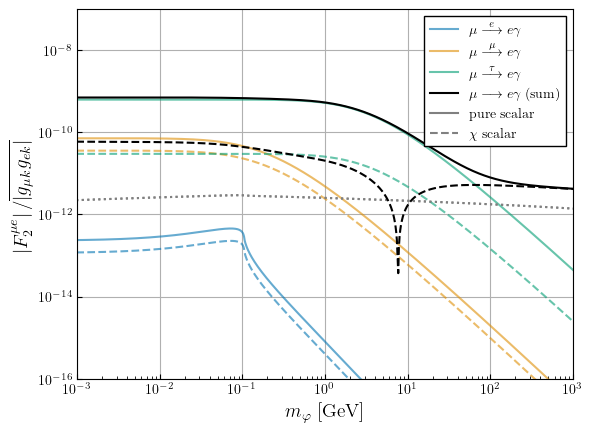

In [28]:
plt.plot(m, np.abs(PC_ALP_F2_mee), color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_mem), color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_met), color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")

plt.plot(m, np.abs(PC_ALP_F2_meg), color = 'grey', linestyle = 'dotted')

plt.plot(m, np.abs(PC_ALP_F2_me), color = 'black', label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, np.abs(chi_ALP_F2_mee), color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_mem), color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_met), color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(PC_ALP_F2_meg), color = 'grey', linestyle = 'dotted')

plt.plot(m, np.abs(chi_ALP_F2_me), color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\mu e}\\right|/\\overline{|g_{\\mu k}g_{e k}|}$", fontsize = 14)
plt.ylim(1e-16,1e-7)
plt.yscale('log')

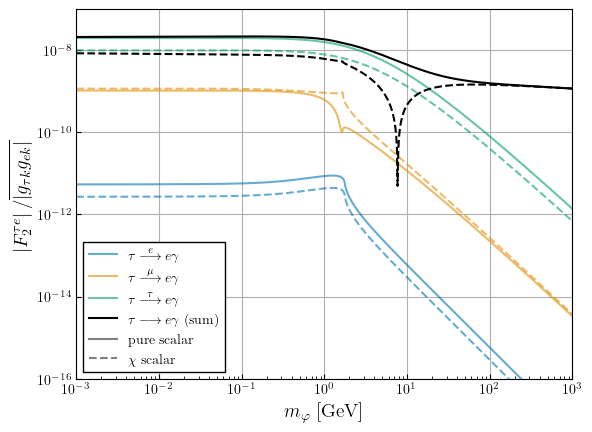

In [29]:
plt.plot(m, np.abs(PC_ALP_F2_tee), color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_tem), color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_tet), color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_te), color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, np.abs(chi_ALP_F2_tee), color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_tem), color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_tet), color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_te), color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\tau e}\\right|/\\overline{|g_{\\tau k}g_{e k}|}$", fontsize = 14)
plt.ylim(1e-16,1e-7)
plt.yscale('log')

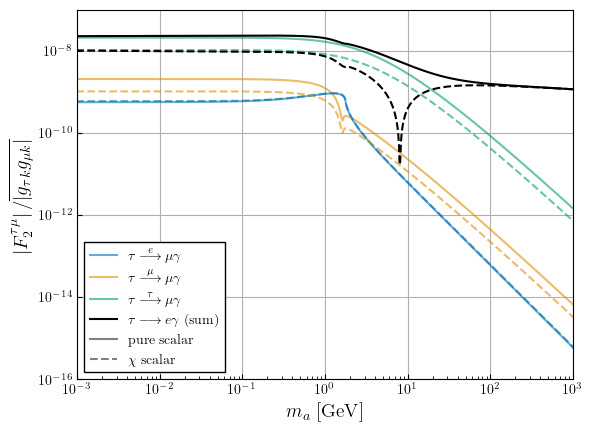

In [30]:
plt.plot(m, np.abs(PC_ALP_F2_tme), color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_tmm), color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_tmt), color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, np.abs(PC_ALP_F2_tm), color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, np.abs(chi_ALP_F2_tme), color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_tmm), color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_tmt), color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, np.abs(chi_ALP_F2_tm), color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\left|F_2^{\\tau \\mu}\\right|/\\overline{|g_{\\tau k}g_{\\mu k}|}$", fontsize = 14)
plt.ylim(1e-16,1e-7)
plt.yscale('log')

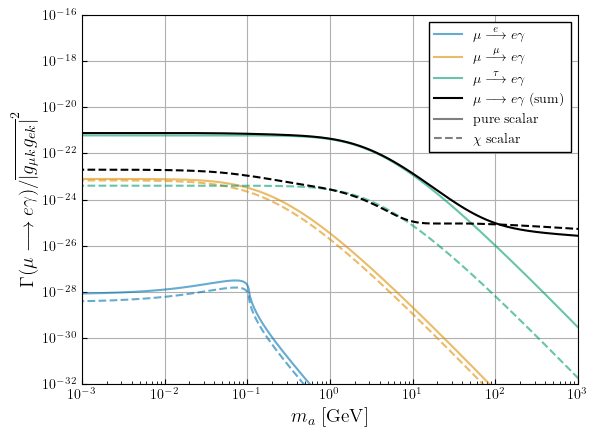

In [31]:
plt.plot(m, PC_ALP_rate_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_me, color = 'black', label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_me, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\mu \\longrightarrow e\\gamma)/\\overline{|g_{\\mu k}g_{e k}|}^2$", fontsize = 14)
plt.ylim(1e-32,1e-16)
plt.yscale('log')

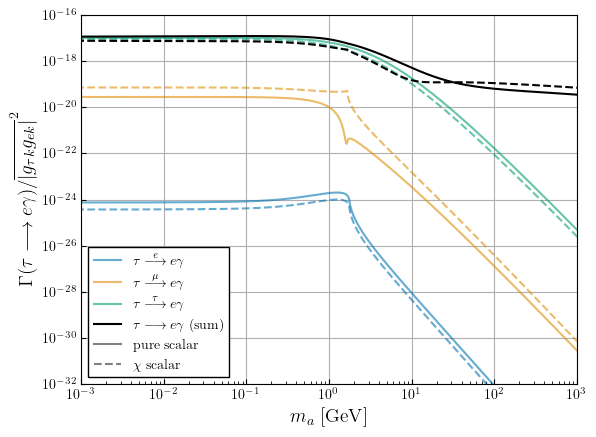

In [32]:
plt.plot(m, PC_ALP_rate_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_te, color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_te, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\tau \\longrightarrow e\\gamma)/\\overline{|g_{\\tau k}g_{e k}|}^2$", fontsize = 14)
plt.ylim(1e-32,1e-16)
plt.yscale('log')

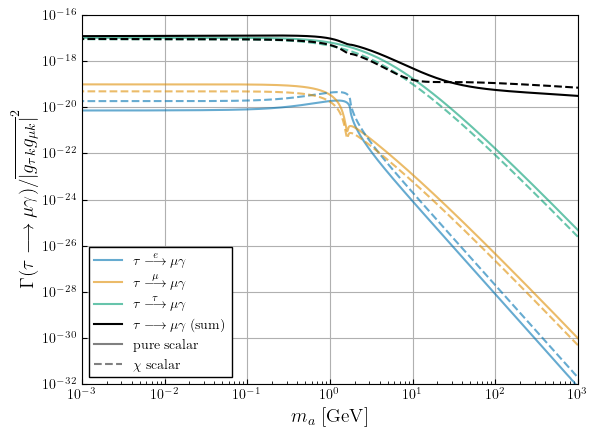

In [33]:
plt.plot(m, PC_ALP_rate_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tm, color = 'black', label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tm, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 1, edgecolor = 'black', fontsize = 10)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\tau \\longrightarrow \\mu\\gamma)/\\overline{|g_{\\tau k}g_{\\mu k}|}^2$", fontsize = 14)
plt.ylim(1e-32,1e-16)
plt.yscale('log')

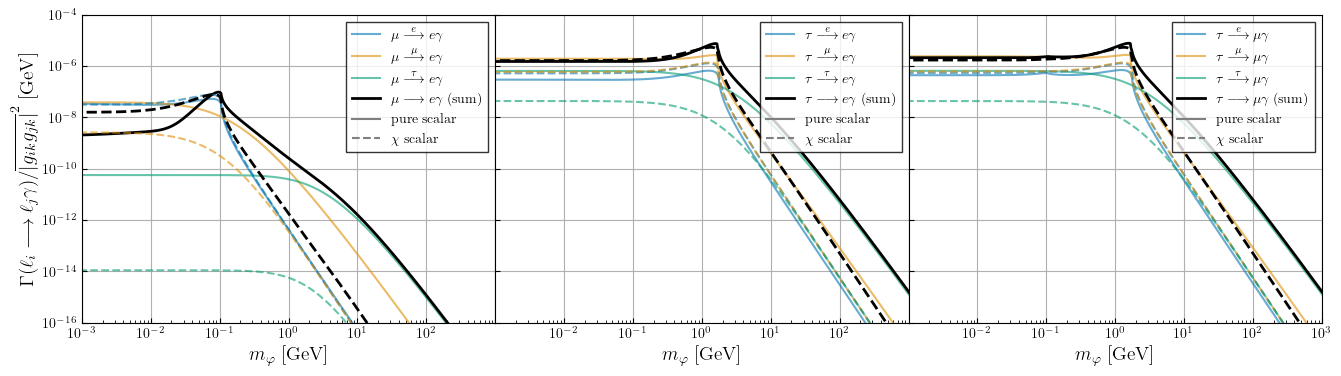

In [34]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 3, wspace = 0)  # hspace=0 removes gap

# First plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])
ax1.tick_params(which = 'both', direction = 'in')

plt.plot(m, PC_scalar_rate_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_me, color = 'black', linewidth = 2, label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_me, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\ell_i \\longrightarrow \\ell_j\\gamma)/\\overline{|g_{i k}g_{j k}|}^2~[\\textrm{GeV}]$", fontsize = 14)
plt.ylim(1e-16,1e-4)
plt.yscale('log')

ax1.set_xticks([1e-3,1e-2,1e-1,1e0,1e1,1e2])

# Second plot:
ax2 = fig.add_subplot(gs[1], sharey = ax1)
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_scalar_rate_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_rate_te, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_te, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

ax2.set_xticks([1e-2,1e-1,1e0,1e1,1e2])

# Third plot:
ax3 = fig.add_subplot(gs[2], sharey = ax1)
ax3.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_scalar_rate_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_rate_tm, color = 'black', linewidth = 2, label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_scalar_rate_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_rate_tm, color = 'black', linestyle = 'dashed', linewidth = 2)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

ax3.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3])

#plt.savefig('complex_scalar_LFV_rates.pdf')

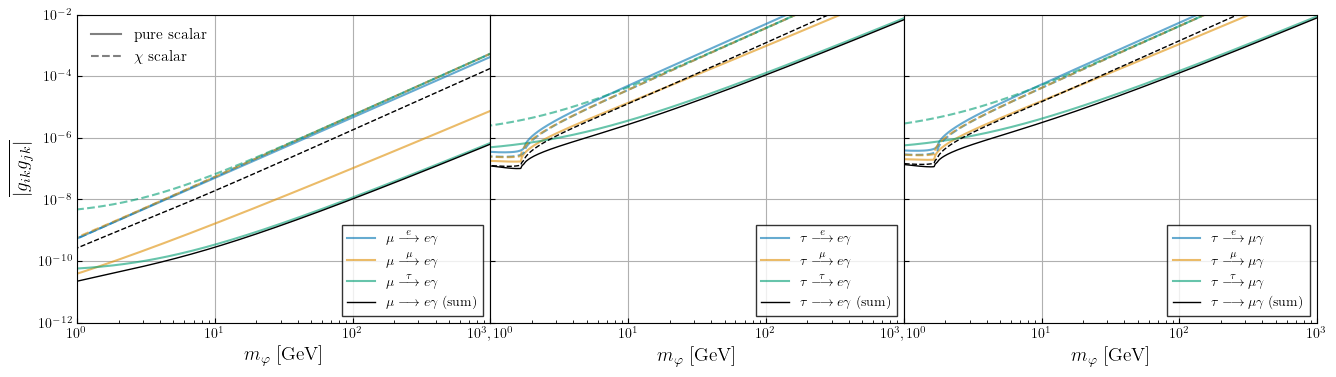

In [36]:
branching_me_limit = 4.2e-13
branching_te_limit = 3.3e-8
branching_tm_limit = 4.4e-8

decay_width_m = 2.99e-19
decay_width_t = 2.27e-12

decay_width_me = branching_me_limit * decay_width_m
decay_width_te = branching_te_limit * decay_width_t
decay_width_tm = branching_tm_limit * decay_width_t

PC_scalar_limit_mee = np.sqrt(decay_width_me/PC_scalar_rate_mee)
PC_scalar_limit_mem = np.sqrt(decay_width_me/PC_scalar_rate_mem)
PC_scalar_limit_met = np.sqrt(decay_width_me/PC_scalar_rate_met)
PC_scalar_limit_me = np.sqrt(decay_width_me/PC_scalar_rate_me)

chi_scalar_limit_mee = np.sqrt(decay_width_me/chi_scalar_rate_mee)
chi_scalar_limit_mem = np.sqrt(decay_width_me/chi_scalar_rate_mem)
chi_scalar_limit_met = np.sqrt(decay_width_me/chi_scalar_rate_met)
chi_scalar_limit_me = np.sqrt(decay_width_me/chi_scalar_rate_me)

PC_scalar_limit_tee = np.sqrt(decay_width_te/PC_scalar_rate_tee)
PC_scalar_limit_tem = np.sqrt(decay_width_te/PC_scalar_rate_tem)
PC_scalar_limit_tet = np.sqrt(decay_width_te/PC_scalar_rate_tet)
PC_scalar_limit_te = np.sqrt(decay_width_te/PC_scalar_rate_te)

chi_scalar_limit_tee = np.sqrt(decay_width_te/chi_scalar_rate_tee)
chi_scalar_limit_tem = np.sqrt(decay_width_te/chi_scalar_rate_tem)
chi_scalar_limit_tet = np.sqrt(decay_width_te/chi_scalar_rate_tet)
chi_scalar_limit_te = np.sqrt(decay_width_te/chi_scalar_rate_te)

PC_scalar_limit_tme = np.sqrt(decay_width_tm/PC_scalar_rate_tme)
PC_scalar_limit_tmm = np.sqrt(decay_width_tm/PC_scalar_rate_tmm)
PC_scalar_limit_tmt = np.sqrt(decay_width_tm/PC_scalar_rate_tmt)
PC_scalar_limit_tm = np.sqrt(decay_width_tm/PC_scalar_rate_tm)

chi_scalar_limit_tme = np.sqrt(decay_width_tm/chi_scalar_rate_tme)
chi_scalar_limit_tmm = np.sqrt(decay_width_tm/chi_scalar_rate_tmm)
chi_scalar_limit_tmt = np.sqrt(decay_width_tm/chi_scalar_rate_tmt)
chi_scalar_limit_tm = np.sqrt(decay_width_tm/chi_scalar_rate_tm)

# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 3, wspace = 0)  # hspace=0 removes gap

# First plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])
ax1.tick_params(which = 'both', direction = 'in')

plt.plot(m, PC_scalar_limit_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_me, color = 'black', label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$", linewidth = 1)

plt.plot(m, chi_scalar_limit_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_me, color = 'black', linestyle = 'dashed', linewidth = 1)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure scalar}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ scalar}$', linestyle = 'dashed')

#plt.plot(m, scalar_limit_lin_me, color = 'grey', linestyle = 'dotted', linewidth = 1)

handles, labels = ax1.get_legend_handles_labels()

first_legend = ax1.legend(handles[:-2], labels[:-2], fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower right')
ax1.add_artist(first_legend)
ax1.legend(handles[-2:], labels[-2:], frameon = False, loc = 'upper left', fontsize = 11)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1, 1e3)
plt.xscale('log')

plt.ylabel("$\\overline{|g_{i k}g_{j k}|}$", fontsize = 14)
plt.ylim(1e-12,1e-2)
plt.yscale('log')

ax1.set_xticks([1e0,1e1, 1e2], ["$10^0$","$10^1$","$10^2$"])

# Second plot:
ax2 = fig.add_subplot(gs[1], sharey = ax1)
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_scalar_limit_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_scalar_limit_te, color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$", linewidth = 1)

plt.plot(m, chi_scalar_limit_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_te, color = 'black', linestyle = 'dashed', linewidth = 1)

#plt.plot(m, scalar_limit_lin_te, color = 'grey', linestyle = 'dotted', linewidth = 1)

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1, 1e3)
plt.xscale('log')

ax2.set_xticks([1e0, 1e1, 1e2], ["$10^3, 10^0$", "$10^1$", "$10^2$"])

# Third plot:
ax3 = fig.add_subplot(gs[2], sharey = ax1)
ax3.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_scalar_limit_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_limit_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_limit_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_scalar_limit_tm, color = 'black', label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$", linewidth = 1)

plt.plot(m, chi_scalar_limit_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_scalar_limit_tm, color = 'black', linestyle = 'dashed', linewidth = 1)

#plt.plot(m, scalar_limit_lin_tm, color = 'grey', linestyle = 'dotted', linewidth = 1)

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{\\varphi}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1, 1e3)
plt.xscale('log')

ax3.set_xticks([1e0, 1e1, 1e2, 1e3], ["$10^3, 10^0$", "$10^1$", "$10^2$", "$10^3$"])

#plt.savefig('complex_scalar_LFV_rates.pdf')

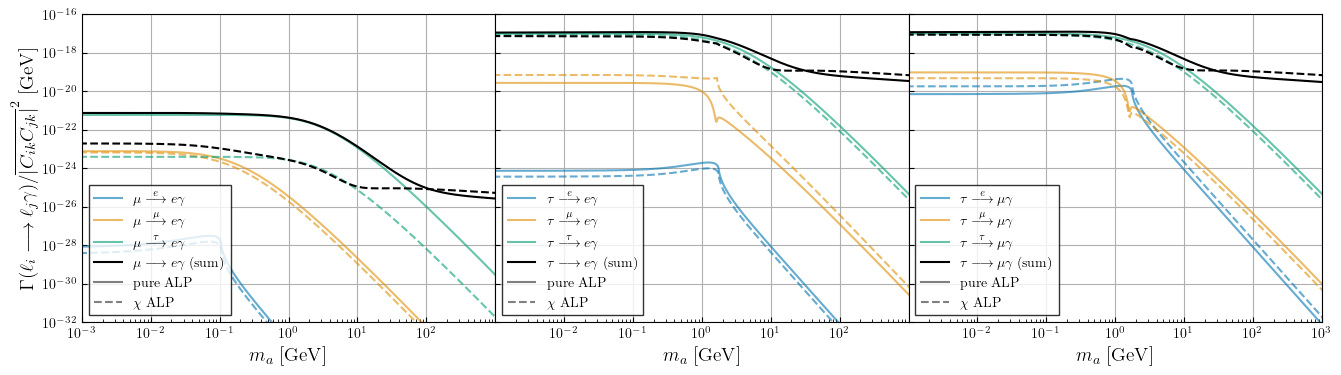

In [37]:
# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 3, wspace = 0)  # hspace=0 removes gap

# First plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])
ax1.tick_params(which = 'both', direction = 'in')

plt.plot(m, PC_ALP_rate_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_me, color = 'black', label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_me, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure ALP}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ ALP}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower left')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

plt.ylabel("$\\Gamma(\\ell_i \\longrightarrow \\ell_j\\gamma)/\\overline{|C_{i k}C_{j k}|}^2~[\\textrm{GeV}]$", fontsize = 14)
plt.ylim(1e-32,1e-16)
plt.yscale('log')

ax1.set_xticks([1e-3,1e-2,1e-1,1e0,1e1,1e2])

# Second plot:
ax2 = fig.add_subplot(gs[1], sharey = ax1)
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_ALP_rate_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$")
plt.plot(m, PC_ALP_rate_te, color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_te, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure ALP}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ ALP}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower left')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

ax2.set_xticks([1e-2,1e-1,1e0,1e1,1e2])


# Third plot:
ax3 = fig.add_subplot(gs[2], sharey = ax1)
ax3.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_ALP_rate_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$")
plt.plot(m, PC_ALP_rate_tm, color = 'black', label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$")

plt.plot(m, chi_ALP_rate_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_rate_tm, color = 'black', linestyle = 'dashed')

plt.plot([1000], color = 'grey', label = '$\\textrm{pure ALP}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ ALP}$', linestyle = 'dashed')

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'lower left')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e-3, 1e3)
plt.xscale('log')

ax3.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3])

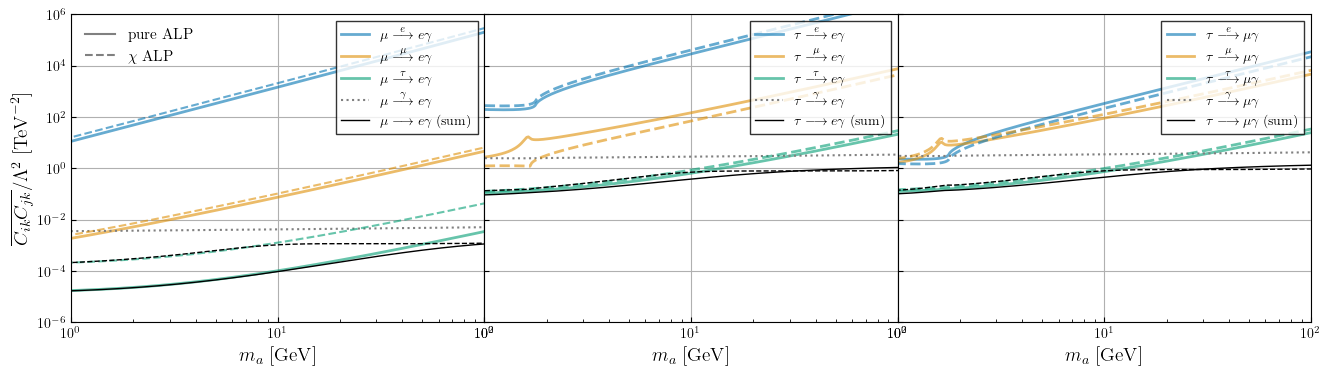

In [45]:
branching_me_limit = 4.2e-13
branching_te_limit = 3.3e-8
branching_tm_limit = 4.4e-8

decay_width_m = 2.99e-19
decay_width_t = 2.27e-12

decay_width_me = branching_me_limit * decay_width_m
decay_width_te = branching_te_limit * decay_width_t
decay_width_tm = branching_tm_limit * decay_width_t

PC_ALP_limit_mee = np.sqrt(decay_width_me/PC_ALP_rate_mee)
PC_ALP_limit_mem = np.sqrt(decay_width_me/PC_ALP_rate_mem)
PC_ALP_limit_met = np.sqrt(decay_width_me/PC_ALP_rate_met)
PC_ALP_limit_meg = np.sqrt(decay_width_me/PC_ALP_rate_meg)
PC_ALP_limit_me = np.sqrt(decay_width_me/PC_ALP_rate_me)

chi_ALP_limit_mee = np.sqrt(decay_width_me/chi_ALP_rate_mee)
chi_ALP_limit_mem = np.sqrt(decay_width_me/chi_ALP_rate_mem)
chi_ALP_limit_met = np.sqrt(decay_width_me/chi_ALP_rate_met)
chi_ALP_limit_meg = np.sqrt(decay_width_me/chi_ALP_rate_meg)
chi_ALP_limit_me = np.sqrt(decay_width_me/chi_ALP_rate_me)

PC_ALP_limit_tee = np.sqrt(decay_width_te/PC_ALP_rate_tee)
PC_ALP_limit_tem = np.sqrt(decay_width_te/PC_ALP_rate_tem)
PC_ALP_limit_tet = np.sqrt(decay_width_te/PC_ALP_rate_tet)
PC_ALP_limit_teg = np.sqrt(decay_width_te/PC_ALP_rate_teg)
PC_ALP_limit_te = np.sqrt(decay_width_te/PC_ALP_rate_te)

chi_ALP_limit_tee = np.sqrt(decay_width_te/chi_ALP_rate_tee)
chi_ALP_limit_tem = np.sqrt(decay_width_te/chi_ALP_rate_tem)
chi_ALP_limit_tet = np.sqrt(decay_width_te/chi_ALP_rate_tet)
chi_ALP_limit_teg = np.sqrt(decay_width_te/chi_ALP_rate_teg)
chi_ALP_limit_te = np.sqrt(decay_width_te/chi_ALP_rate_te)

PC_ALP_limit_tme = np.sqrt(decay_width_tm/PC_ALP_rate_tme)
PC_ALP_limit_tmm = np.sqrt(decay_width_tm/PC_ALP_rate_tmm)
PC_ALP_limit_tmt = np.sqrt(decay_width_tm/PC_ALP_rate_tmt)
PC_ALP_limit_tmg = np.sqrt(decay_width_tm/PC_ALP_rate_tmg)
PC_ALP_limit_tm = np.sqrt(decay_width_tm/PC_ALP_rate_tm)

chi_ALP_limit_tme = np.sqrt(decay_width_tm/chi_ALP_rate_tme)
chi_ALP_limit_tmm = np.sqrt(decay_width_tm/chi_ALP_rate_tmm)
chi_ALP_limit_tmt = np.sqrt(decay_width_tm/chi_ALP_rate_tmt)
chi_ALP_limit_tmg = np.sqrt(decay_width_tm/chi_ALP_rate_tmg)
chi_ALP_limit_tm = np.sqrt(decay_width_tm/chi_ALP_rate_tm)

# Create a figure and use GridSpec to control layout precisely
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 3, wspace = 0)  # hspace=0 removes gap

# First plot: Exact functions and approximation
ax1 = fig.add_subplot(gs[0])
ax1.tick_params(which = 'both', direction = 'in')

plt.plot(m, PC_ALP_limit_mee, color = colors[0], alpha = 0.6, label = "$\\mu\\stackrel{e}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_met, color = colors[2], alpha = 0.6, label = "$\\mu\\stackrel{\\tau}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_meg, color = 'grey', linestyle = 'dotted', label = "$\\mu\\stackrel{\\gamma}{\\longrightarrow} e\\gamma$")
plt.plot(m, PC_ALP_limit_me, color = 'black', label = "$\\mu\\longrightarrow e\\gamma~{\\textrm{(sum)}}$", linewidth = 1)



plt.plot(m, chi_ALP_limit_mee, color = colors[0], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_limit_mem, color = colors[1], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_limit_met, color = colors[2], linestyle = 'dashed', alpha = 0.6)
plt.plot(m, chi_ALP_limit_me, color = 'black', linestyle = 'dashed', linewidth = 1)

plt.plot([1000], color = 'grey', label = '$\\textrm{pure ALP}$')
plt.plot([1000], color = 'grey', label = '$\\chi \\textrm{ ALP}$', linestyle = 'dashed')

handles, labels = ax1.get_legend_handles_labels()

first_legend = ax1.legend(handles[:-2], labels[:-2], fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')
ax1.add_artist(first_legend)
ax1.legend(handles[-2:], labels[-2:], frameon = False, loc = 'upper left', fontsize = 11)

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e0, 1e2)
plt.xscale('log')

plt.ylabel("$\\overline{C_{i k}C_{j k}}/\Lambda^2~[\\textrm{TeV}^{-2}]$", fontsize = 14)
plt.ylim(1e-6,1e6)
plt.yscale('log')

#ax1.set_xticks([1e0,1e1, 1e2], ["$10^0$","$10^1$","$10^2$"])

# Second plot:
ax2 = fig.add_subplot(gs[1], sharey = ax1)
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_ALP_limit_tee, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_tem, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_tet, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}e\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_teg, color = 'grey', linestyle = 'dotted', label = "$\\tau\\stackrel{\\gamma}{\\longrightarrow} e\\gamma$")

plt.plot(m, PC_ALP_limit_te, color = 'black', label = "$\\tau\\longrightarrow e\\gamma~{\\textrm{(sum)}}$", linewidth = 1)

plt.plot(m, chi_ALP_limit_tee, color = colors[0], linestyle = 'dashed', alpha = 0.6, linewidth = 2)
plt.plot(m, chi_ALP_limit_tem, color = colors[1], linestyle = 'dashed', alpha = 0.6, linewidth = 2)
plt.plot(m, chi_ALP_limit_tet, color = colors[2], linestyle = 'dashed', alpha = 0.6, linewidth = 2)

plt.plot(m, chi_ALP_limit_te, color = 'black', linestyle = 'dashed', linewidth = 1)

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e0, 1e2)
plt.xscale('log')

#ax2.set_xticks([1e0, 1e1, 1e2], ["$10^3, 10^0$", "$10^1$", "$10^2$"])

# Third plot:
ax3 = fig.add_subplot(gs[2], sharey = ax1)
ax3.tick_params(which = 'both', direction = 'in', labelleft = False)

plt.plot(m, PC_ALP_limit_tme, color = colors[0], alpha = 0.6, label = "$\\tau\\stackrel{e}{\\longrightarrow}\\mu\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_tmm, color = colors[1], alpha = 0.6, label = "$\\tau\\stackrel{\\mu}{\\longrightarrow}\\mu\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_tmt, color = colors[2], alpha = 0.6, label = "$\\tau\\stackrel{\\tau}{\\longrightarrow}\\mu\\gamma$", linewidth = 2)
plt.plot(m, PC_ALP_limit_tmg, color = 'grey', linestyle = 'dotted', label = "$\\tau\\stackrel{\\gamma}{\\longrightarrow} \\mu\\gamma$")

plt.plot(m, PC_ALP_limit_tm, color = 'black', label = "$\\tau\\longrightarrow \\mu\\gamma~{\\textrm{(sum)}}$", linewidth = 1)

plt.plot(m, chi_ALP_limit_tme, color = colors[0], linestyle = 'dashed', alpha = 0.6, linewidth = 2)
plt.plot(m, chi_ALP_limit_tmm, color = colors[1], linestyle = 'dashed', alpha = 0.6, linewidth = 2)
plt.plot(m, chi_ALP_limit_tmt, color = colors[2], linestyle = 'dashed', alpha = 0.6, linewidth = 2)
plt.plot(m, chi_ALP_limit_tm, color = 'black', linestyle = 'dashed', linewidth = 1)

plt.legend(fancybox = False, framealpha = 0.8, edgecolor = 'black', fontsize = 10, loc = 'upper right')

plt.tick_params(which = 'both', direction = 'in')

plt.gca().grid()

plt.xlabel("$m_{a}~[{\\textrm{GeV}}]$", fontsize = 14)
plt.xlim(1e0, 1e2)
plt.xscale('log')

#ax3.set_xticks([1e0, 1e1, 1e2, 1e3], ["$10^3, 10^0$", "$10^1$", "$10^2$", "$10^3$"])


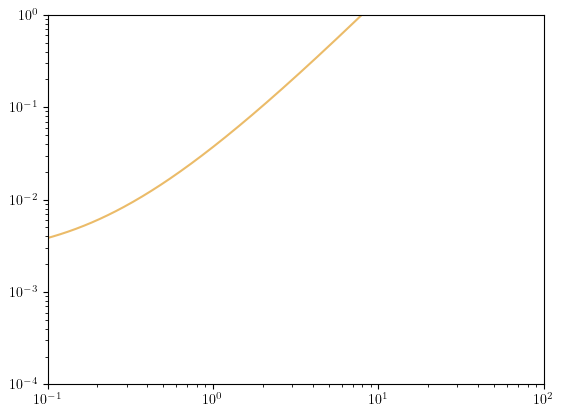

In [207]:
plt.plot(m, (2*np.pi**2)*PC_ALP_limit_mem, color = colors[1], alpha = 0.6, label = "$\\mu\\stackrel{\\mu}{\\longrightarrow}e\\gamma$")

plt.ylim(1e-4,1e0)
plt.xlim(1e-1,100)
plt.xscale('log')
plt.yscale('log')

In [208]:
def g1(x):
    return 2*x**(3/2)*np.sqrt(4-x)*np.arccos(np.sqrt(x)/2)+1-2*x+x**2 * (3-x)/(1-x)*np.log(x)

def g1p(x):
    return -2*x**(3/2)*np.sqrt(x-4)*np.log((np.sqrt(x) + np.sqrt(x-4))/2)+1-2*x+x**2 * (3-x)/(1-x)*np.log(x)

e = np.sqrt(4*np.pi*alpha)

F2 = -e*mm/(64*np.pi*Lam**2)*(1 + 1)* g1p(m**2/mm**2)
rate = mm**3 *np.abs(F2)**2/(8*np.pi)

F2p = mm**2/(16*np.pi**2*Lam**2)*g1p(m**2/mm**2)
ratep = alpha*mm/2 * np.abs(F2p)**2

PC_ALP_F2_mem = (mm + mm)*(me + mm) * (fp_mem - fm_mem)/(32*np.pi**2 * m * Lam**2)


PC_ALP_F2_mem_p = 2*(me + mm) * g1p(xm)/(32*np.pi**2 * Lam**2)